## Table of Contents

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IPL-UV/ee_ipl_uv/blob/master/examples/cloudscore_different_preds.ipynb)

* [Persistence method](#Persistence-method)
* [Percentile method](#Percentile-method)
* [Percentile method without threshold in reflectance](#Percentile-method-without-threshold-in-reflectance)
* [Percentile method without clustering](#Percentile-method-without-clustering)
* [Linear method](#Linear-method)
* [Kernel method](#Kernel-method)


The following code contains examples of appplying the different multitemporal cloud detection methodologies proposed in ([Mateo-Garcia et al 2018](http://dx.doi.org/10.3390/rs10071079)). The current script is prepared to run on one of the 2661 patches from the study. However, it could be run on any Landsat 8 image just by changing the `image_predict_clouds` variable and the `pol` variable.


In [ ]:
# # To be run in google colab.
!pip install git+https://github.com/IPL-UV/ee_ipl_uv#egg=ee_ipl_uv
!earthengine authenticate

In [1]:
import ee
from datetime import datetime
from IPython.display import Image, display,HTML
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download
import os
import requests
import re
from datetime import datetime

OLD_FORMAT = "L\w{1}\d{1}(\d{3})(\d{3})(\d{7})\w{3}\d{2}"

def l8_old_format_name_to_new(l8name):    
    matches =  re.match(OLD_FORMAT, l8name)
    wrdpath, wsdrow, sensing_date_julian = matches.groups()
    return "LC08_%s%s_%s"%(wrdpath, wsdrow, datetime.strptime(sensing_date_julian, '%Y%j').strftime("%Y%m%d"))

ee.Initialize()

# Select image to remove clouds

image_from_article = True
# Images from article have an associated ground truth from the Biome dataset
image_collection_name = 'LANDSAT/LC08/C01/T1_TOA/'

if image_from_article:
    image_index_old = "LC80290372013257LGN00"
    image_index_new = l8_old_format_name_to_new(image_index_old)
    # Region of interest from the article
    r = requests.get(url="http://isp.uv.es/projects/cdc/GEE_CLOUDS/locations_splits.json",verify=False)
    locations=r.json()
    split = "013_011"
    # Select region of interest (lng,lat)
    pol = [[p[1],p[0]] for p in locations[image_index_old][split][0]]
    
    image_predict_clouds = ee.Image(image_collection_name+image_index_new)
else:
    image_index_new = "LC08_199032_20150826"
    # Custom region of interest
    pol = [[-0.50262451171875,39.39269330108945],
           [-0.267791748046875,39.38526381099777],
           [-0.26092529296875,39.54005788576377],
           [-0.501251220703125,39.53793974517628],
           [-0.50262451171875,39.39269330108945]]
    image_predict_clouds = ee.Image(image_collection_name+image_index_new)
    
region_of_interest = ee.Geometry.Polygon(pol)
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")

/home/gonzalo/miniconda3/envs/ee/lib/python3.8/site-packages/urllib3/connectionpool.py:997: InsecureRequestWarning: Unverified HTTPS request is being made to host 'isp.uv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [2]:
# Vis image
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])
image_file_original = download.MaybeDownloadThumb(imageRGB.clip(region_of_interest),params={"dimensions": "400x400"})

def viz_cloudscore_mask(cloudscoremask):
    cloudscoremask_vis = cloudscoremask.updateMask(cloudscoremask)
    cloudscoremask_vis = cloudscoremask_vis.visualize(max=1,min=0,palette=['1f77b4', 'ff7f0e'])
    mosaic = ee.ImageCollection([imageRGB, cloudscoremask_vis]).mosaic()
    return download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})


## Vis ground truth

In [3]:
if image_from_article:
    ground_truth = ee.Image("users/gonzmg88/LANDSAT8_CLOUDS/"+image_index_old+"_fixedmask")
    ground_truth = ground_truth.eq(192).Or(ground_truth.eq(255))
    mosaic_GT_file = viz_cloudscore_mask(ground_truth)
    
    def viz_compare_with_gt(cloudscoremask):
        viz_compairson = cloudscoremask.add(ground_truth.toInt16().multiply(2))
        viz_compairson = viz_compairson.updateMask(viz_compairson)
        viz_compairson = viz_compairson.visualize(max=3,min=0,palette=['000000','1f77b4', 'ff7f0e','ffffff'])
        viz_compairson = ee.ImageCollection([imageRGB, viz_compairson]).mosaic()
        return download.MaybeDownloadThumb(viz_compairson.clip(region_of_interest),
                                           params={"dimensions": "400x400"})


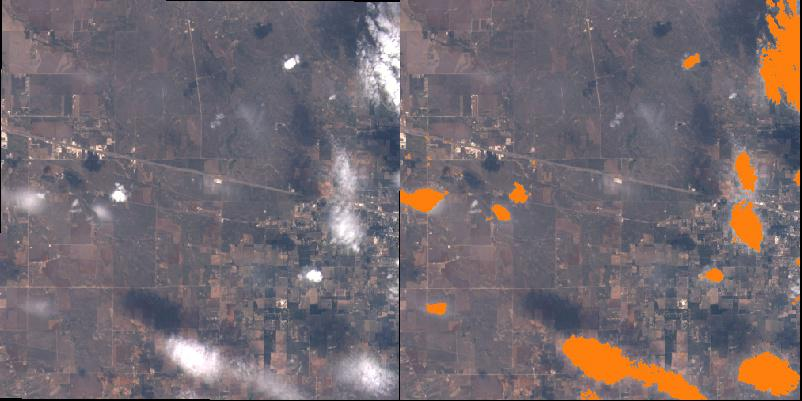

In [4]:
if image_from_article:
    img_files_composite_per = download.MosaicImageList([image_file_original,mosaic_GT_file],
                                                       [1,2])

    display(Image(img_files_composite_per),
           HTML("<center>Landsat 8 TOA image %s with ground truth mask</center>"%datetime_image))

## Persistence method

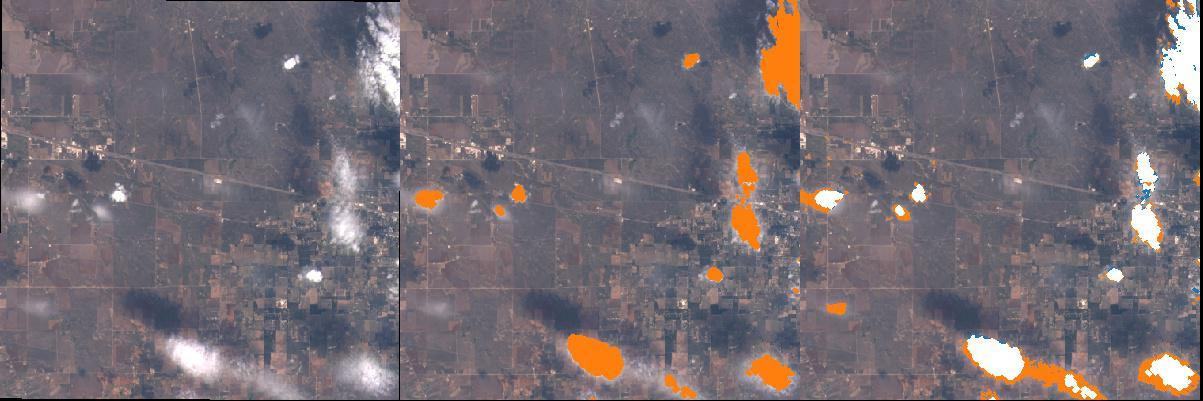

In [5]:
# Vis image + cloud mask
# Obtain cloud mask (2: cloud,1: shadow, 0: clear)
from ee_ipl_uv import image_wrapper
image_wrap = image_wrapper.L8L1TImage(image_index_new,image_collection_name)
cloud_score_persistence,pred_persistence = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                         method_pred="persistence")

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_persistence)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_persistence))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore from persistence method cloud mask</center>"%datetime_image))

## Percentile method

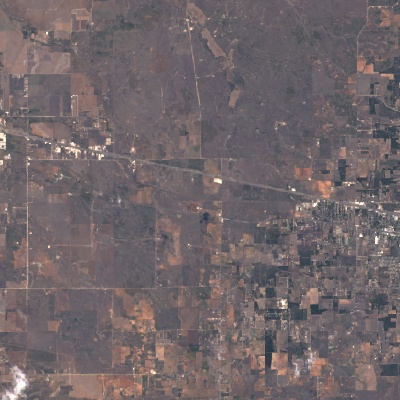

In [6]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                      method_pred="percentile",
                                                                                       num_images=3)
percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(percentile_pred_file),
        HTML("<center>Percentile prediction</center>"))

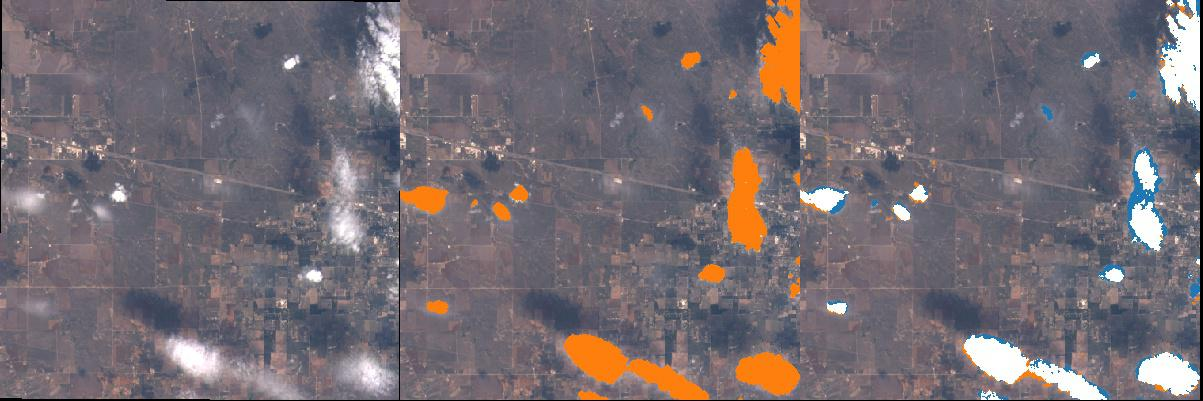

In [7]:
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_percentile))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Percentile method without threshold in reflectance

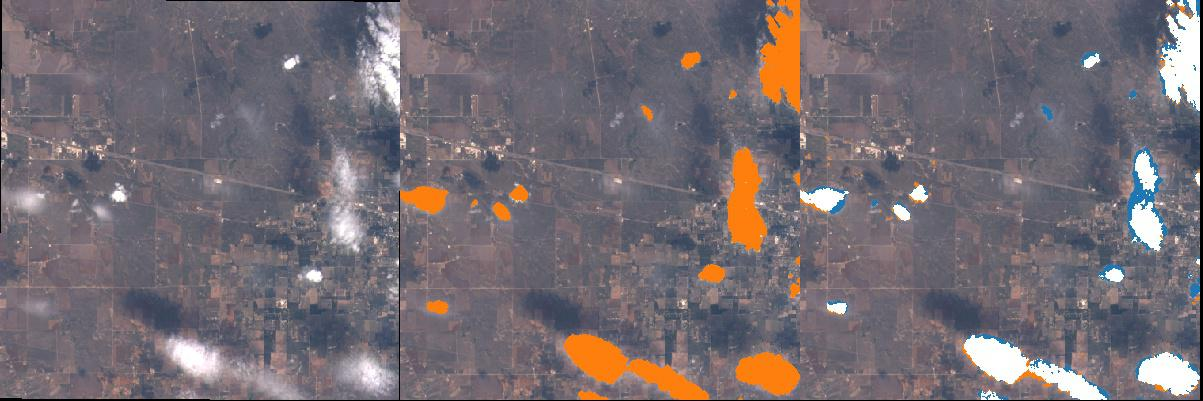

In [8]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"threshold_reflectance":0},
                                                                                       num_images=3)

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_percentile))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])
display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Percentile method without clustering

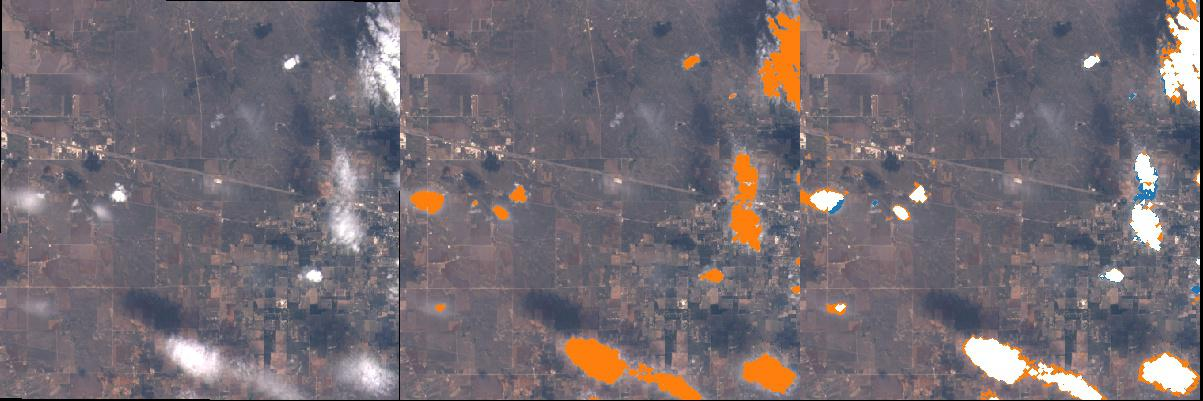

In [9]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"do_clustering":False},
                                                                                       num_images=3)
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_percentile))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Linear method

In [11]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Create a folder called ee_ipl_uv_downloads inyour google drive
!mkdir /content/drive/My Drive/ee_ipl_uv_downloads

In [12]:
from ee_ipl_uv import download
import logging
import sys
def screen_logger(logger,level=logging.INFO):
    logger.setLevel(level)
    formatter = logging.Formatter(
       '%(asctime)-12s %(name)-12s %(levelname)-8s %(message)s',
       datefmt="%Y-%m-%d %H:%M:%S")
    
    # logger to stdout
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(level)
    handler.setFormatter(formatter)
    logger.addHandler(handler)

screen_logger(download.logger)
screen_logger(multitemporal_cloud_masking.logger)
download.logger.info("Turn on logging")

2018-10-03 11:45:59 ee_ipl_uv.download INFO     Turn on logging


2018-10-03 11:47:26 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-10-03 11:48:38 ee_ipl_uv.download INFO     ee.task COMPLETED 60s. Starting download from Google Drive
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=1029168929748-2geumoootp6420gk2p4vvog28iinat0n.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



/home/gonzalo/miniconda3/envs/p36/lib/python3.6/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access mycreds.txt: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


Authentication successful.
2018-10-03 11:48:44 ee_ipl_uv.download INFO     Downloading image pandas_ftcolaig8ny4q.csv from drive
2018-10-03 11:48:48 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (24649, 36)


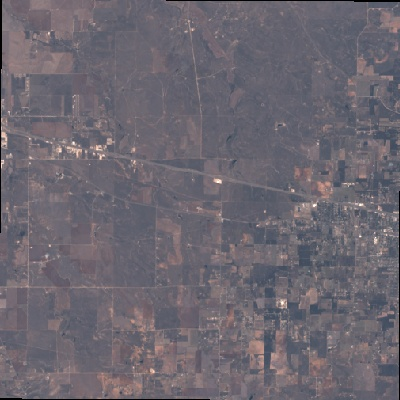

In [13]:
cloud_score_linear,pred_linear = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                               method_pred="linear",
                                                                               num_images=3)

pred_linear_file = download.MaybeDownloadThumb(pred_linear.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_linear_file),
        HTML("<center>Linear method prediction</center>"))

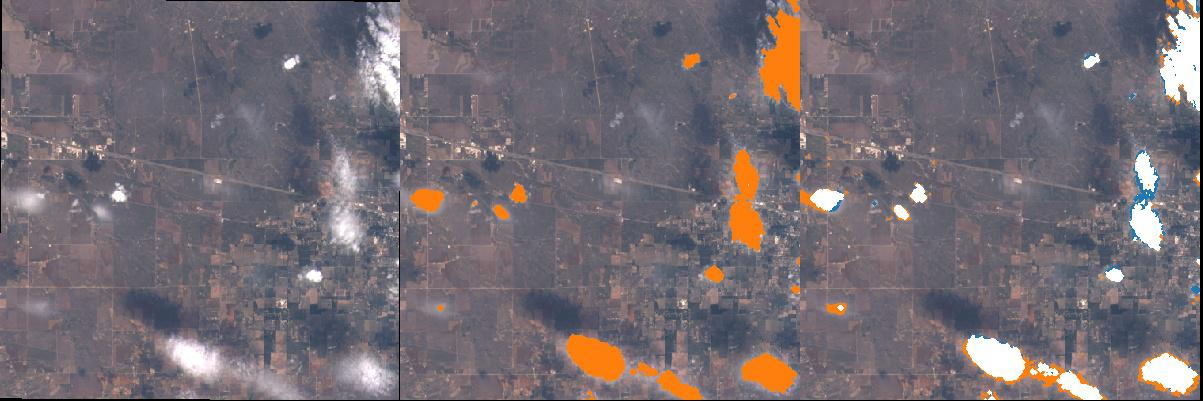

In [14]:
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_linear)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_linear))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of linear method cloud mask</center>"%datetime_image))


## Kernel method

2018-10-03 11:49:24 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-10-03 11:49:36 ee_ipl_uv.download INFO     ee.task COMPLETED 10s. Starting download from Google Drive
2018-10-03 11:49:37 ee_ipl_uv.download INFO     Downloading image pandas_ftcol8pp0um0v.csv from drive
2018-10-03 11:49:38 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (26, 36)


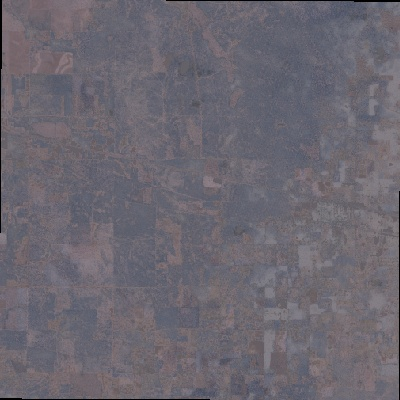

In [15]:
cloud_score_kernel,pred_kernel = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,
                                                                               region_of_interest,
                                                                               method_pred="kernel",num_images=3,
                                                                               params={"sampling_factor":0.00005,
                                                                                       "lmbda": 0.001,
                                                                                       "do_clustering":False,
                                                                                      "gamma": 0.011})

pred_kernel_file = download.MaybeDownloadThumb(pred_kernel.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_kernel_file),
        HTML("<center>Kernel method prediction</center>"))

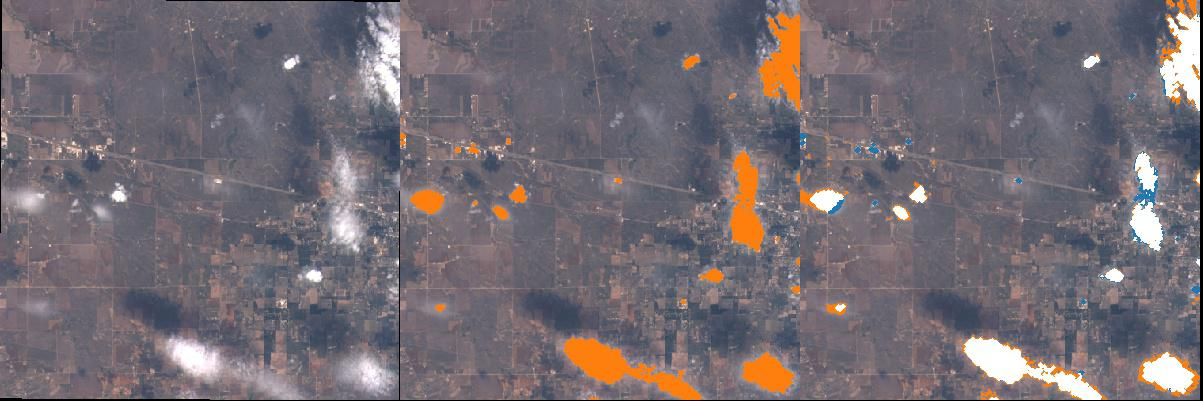

In [16]:
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_kernel)]
if image_from_article:
    list_images_show.append(viz_compare_with_gt(cloud_score_kernel))

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])
display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of kernel method cloud mask</center>"%datetime_image))